## Data cleaning 

**Import Modules**

In [1]:
from pyspark.sql.session import SparkSession
from pyspark.sql import functions as F

from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import DenseVector
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA, OneHotEncoder, StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
from pyspark.sql.functions import isnan, when, count, col

In [2]:
# Data Manipulation
import numpy as np 
import pandas as pd

In [3]:
import os
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

**Read csv file**

In [4]:
filename = 'data.csv'
df = spark.read.csv(filename, inferSchema=True, header = True)

In [5]:
type(df)

pyspark.sql.dataframe.DataFrame

In [6]:
df.toPandas()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,['Mamie Smith'],0.598,168333,0.22399999999999998,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.379,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.634,1920
1,0.643000,"""[""""Screamin' Jay Hawkins""""]""",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.0264,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.95,1920
2,0.993000,['Mamie Smith'],0.647,163827,0.18600000000000005,0,11m7laMUgmOKqI3oYzuhne,1.76e-05,0,0.519,-12.097999999999999,1,Golfing Papa,4,1920,0.174,97.6,0.6890000000000001,1920
3,0.000173,['Oscar Velazquez'],0.73,422087,0.7979999999999999,0,19Lc5SfJJ5O1oaxY0fpwfh,0.8009999999999999,2,0.128,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.99700000000001,0.0422,1920
4,0.295000,['Mixe'],0.7040000000000001,165224,0.7070000000000001,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.402,-6.0360000000000005,0,Xuniverxe,2,1920-10-01,0.0768,122.07600000000001,0.299,1920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174384,0.009170,"['DJ Combo', 'Sander-7', 'Tony T']",0.792,147615,0.866,0,46LhBf6TvYjZU2SMvGZAbn,5.99e-05,6,0.17800000000000002,-5.0889999999999995,0,The One,0,2020-12-25,0.0356,125.97200000000001,0.18600000000000005,2020
174385,0.795000,['Alessia Cara'],0.429,144720,0.21100000000000002,0,7tue2Wemjd0FZzRtDrQFZd,0.0,4,0.196,-11.665,1,A Little More,0,2021-01-22,0.036000000000000004,94.71,0.228,2021
174386,0.806000,['Roger Fly'],0.6709999999999999,218147,0.589,0,48Qj61hOdYmUCFJbpQ29Ob,0.92,4,0.113,-12.392999999999999,0,Together,0,2020-12-09,0.0282,108.05799999999999,0.7140000000000001,2020
174387,0.920000,['Taylor Swift'],0.462,244000,0.24,1,1gcyHQpBQ1lfXGdhZmWrHP,0.0,0,0.113,-12.077,1,champagne problems,69,2021-01-07,0.0377,171.31900000000005,0.32,2021


In [7]:
df.describe().toPandas()

,summary,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,count,174389,174389,174389,174389,174389,174389,174389,174389,174389,174389,174389,174389,174389,174389,174389,174389,174389,174389,174389
1,mean,0.49922848176599677,None,0.5370523995558104,232284.03395898826,518.2371626470293,174.1416269679832,14927.623620614037,32.94695299805832,21.388088201474527,1.66301173445764,-11.698115351441007,5.675269737753432,Infinity,25.786782620242132,1934.6745386555776,4.983288235465753,118.34591427078196,2.0089549379621943,1963.043676547758
2,stddev,0.3799358418737294,None,0.17583673837421163,148621.53735035623,13208.06780918476,7675.583758722449,67101.99688124635,2935.172877189685,2243.6529763824574,601.9192341606113,5.724540360638434,1728.9408688035012,NaN,21.87570035131848,1380.569156399337,97.29810079523408,66.39255207990006,44.693918091783374,167.80279172869677
3,min,0.0,"""[""""'In The Heights' Original Broadway Company""""","""""Kamehameha Schools Children's Chorus""""]""","""""Boys' Choir Of Ipswich School Preparatory D...","""""Lidija Kaz'mina""""","""""Bobby D'Ambrosio""""]""","""""Orchestra Sinfonica dell'EIAR di Torino""""]""",'Benjamin Schrader','J. Robert Spencer',"'Jason Michael Snow']""","'David Baxter']""",'Peter Gregus',"'Richard Hester']""","1944""","""""L'amour est un oiseau rebelle"""" (Carmen","""""Venezianisches Gondellied"""" (arr. A. Segovia)""","Abdallo]""",Alcade,Alcade
4,max,0.996,['조정현'],0.988,99997,99093,900000,95160,9e-06,95361,9.53e-06,9,9,텅 빈 마음 Empty Heart,You Turned The Tables On Me,Want Love - Club Mix,You Did It,When Your Lover Has Gone,What A Woman,Incredible Phat (The Coldest Night of the Year...


**Drop Variables**

In [8]:
# Variables id, name, release_date are not related to our question.
# Thus, droping all three.
df = df.drop("id", "name", "release_date","key","explicit","mode")

**Convert Data Type**

In [9]:
floats = ["acousticness", "danceability", "energy", "instrumentalness", "liveness", "loudness",
         "speechiness", "tempo", "valence"]
for i in floats:
        df = df.withColumn(i, df[i].cast(FloatType()))

ints = ["duration_ms", "popularity", "year"]
for i in ints:
    df = df.withColumn(i, df[i].cast(IntegerType()))

In [10]:
# With Correct Variable Type
df.createOrReplaceTempView("df")
spark.sql("select * from df").show(5)

+------------+--------------------+------------+-----------+------+----------------+--------+--------+----------+-----------+-------+-------+----+
|acousticness|             artists|danceability|duration_ms|energy|instrumentalness|liveness|loudness|popularity|speechiness|  tempo|valence|year|
+------------+--------------------+------------+-----------+------+----------------+--------+--------+----------+-----------+-------+-------+----+
|       0.991|     ['Mamie Smith']|       0.598|     168333| 0.224|         5.22E-4|   0.379| -12.628|        12|     0.0936|149.976|  0.634|1920|
|       0.643|"[""Screamin' Jay...|       0.852|     150200| 0.517|          0.0264|  0.0809|  -7.261|         7|     0.0534| 86.889|   0.95|1920|
|       0.993|     ['Mamie Smith']|       0.647|     163827| 0.186|         1.76E-5|   0.519| -12.098|         4|      0.174|   97.6|  0.689|1920|
|     1.73E-4| ['Oscar Velazquez']|        0.73|     422087| 0.798|           0.801|   0.128|  -7.311|        17|     

In [11]:
df.printSchema()

root
 |-- acousticness: float (nullable = true)
 |-- artists: string (nullable = true)
 |-- danceability: float (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- energy: float (nullable = true)
 |-- instrumentalness: float (nullable = true)
 |-- liveness: float (nullable = true)
 |-- loudness: float (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- speechiness: float (nullable = true)
 |-- tempo: float (nullable = true)
 |-- valence: float (nullable = true)
 |-- year: integer (nullable = true)



**Duplicates & Nulls**

In [12]:
# Count rows and unique rows
print('Rows = {}'.format(df.count()))
print('Distinct Rows = {}'.format(df.distinct().count()))

Rows = 174389
Distinct Rows = 170929


In [13]:
# Check
# Drop all duplicates 
df = df.dropDuplicates()
print('The number of rows with duplicate data removed = {}'.format(df.count()))

The number of rows with duplicate data removed = 170929


In [14]:
# Check for NULL
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+------------+-------+------------+-----------+------+----------------+--------+--------+----------+-----------+-----+-------+----+
|acousticness|artists|danceability|duration_ms|energy|instrumentalness|liveness|loudness|popularity|speechiness|tempo|valence|year|
+------------+-------+------------+-----------+------+----------------+--------+--------+----------+-----------+-----+-------+----+
|           0|      0|           0|          0|     0|               0|       0|       0|         0|          0|    0|      0|   0|
+------------+-------+------------+-----------+------+----------------+--------+--------+----------+-----------+-----+-------+----+



In [15]:
df = df.dropna()

In [16]:
df = df.where((df.popularity > 0))

**Numeric Variables & Categorical Variables**

In [17]:
num_cols = []
cat_cols = []

for s in df.schema:
    data_type = str(s.dataType)
    if data_type == "StringType":
        cat_cols.append(s.name)
    
    #if data_type == "FloatType" or data_type == "IntType" or data_type =="String":
    else:
        num_cols.append(s.name)

In [18]:
print(num_cols)
print(cat_cols)

['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'popularity', 'speechiness', 'tempo', 'valence', 'year']
['artists']


In [19]:
# Correlation
import six
for i in df.columns:
    if not(isinstance(df.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to popularity for ", i, df.stat.corr('popularity',i))

Correlation to popularity for  acousticness -0.3705703416027241
Correlation to popularity for  danceability 0.18216015320012835
Correlation to popularity for  duration_ms 0.04189584884824749
Correlation to popularity for  energy 0.28165138917120447
Correlation to popularity for  instrumentalness -0.23654918610712633
Correlation to popularity for  liveness -0.09382430441193311
Correlation to popularity for  loudness 0.325542988444963
Correlation to popularity for  popularity 1.0
Correlation to popularity for  speechiness -0.05484896484086443
Correlation to popularity for  tempo 0.06158663146470615
Correlation to popularity for  valence 0.03496577750456546
Correlation to popularity for  year 0.56541999233624


## EDA

In [20]:
df_pandas = df.toPandas()
df_pandas.head()

,acousticness,artists,danceability,duration_ms,energy,instrumentalness,liveness,loudness,popularity,speechiness,tempo,valence,year
0,0.995,['Louis Armstrong & His Hot Five'],0.644,151960,0.1230,0.858,0.2180,-18.648001,4,0.3940,189.669998,0.7870,1925
1,0.942,['Jelly Roll Morton'],0.711,174427,0.6350,0.882,0.0744,-5.458000,1,0.0479,104.181000,0.7440,1925
2,0.996,['Louis Armstrong & His Hot Five'],0.676,193387,0.0337,0.740,0.1140,-19.827000,6,0.0540,114.371002,0.5510,1926
3,0.984,['Benny Goodman'],0.223,170133,0.3320,0.853,0.9460,-9.581000,9,0.0430,62.153000,0.0383,1928
4,0.994,"['Jack Teagarden', 'Ben Pollack & His Orchestra']",0.866,178453,0.3730,0.108,0.1270,-15.287000,5,0.2000,112.742996,0.9500,1930


### Examining Different Metrics Over the Years

In [21]:
df_agg = df_pandas.groupby('year').agg({'danceability':'mean', 'instrumentalness':'mean', 'loudness':'mean', 'tempo':'mean'})
df_agg.head()

,danceability,instrumentalness,loudness,tempo
year,,,,
1920,0.512324,0.343355,-13.530107,119.555107
1921,0.413743,0.423914,-19.369400,99.706802
1922,0.532500,0.372108,-13.671500,122.212997
1923,0.624920,0.299002,-12.645070,116.264473
1924,0.633205,0.355251,-11.815000,120.127861


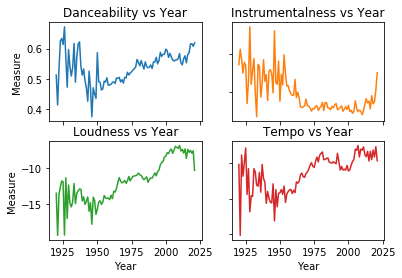

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(df_agg.index, df_agg['danceability'])
axs[0, 0].set_title('Danceability vs Year')
axs[0, 1].plot(df_agg.index, df_agg['instrumentalness'], 'tab:orange')
axs[0, 1].set_title('Instrumentalness vs Year')
axs[1, 0].plot(df_agg.index, df_agg['loudness'], 'tab:green')
axs[1, 0].set_title('Loudness vs Year')
axs[1, 1].plot(df_agg.index, df_agg['tempo'], 'tab:red')
axs[1, 1].set_title('Tempo vs Year')

for ax in axs.flat:
    ax.set(xlabel='Year', ylabel='Measure')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

### Exploring Distribution of Popularity

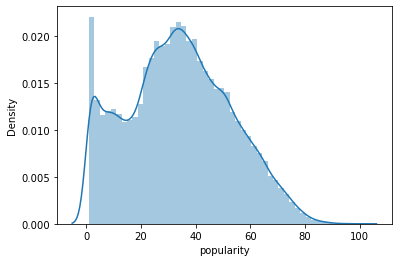

In [31]:
sample_df = df.select(['popularity']).sample(False, 0.5, 42)
sample_df = sample_df.toPandas()

sns.distplot(sample_df)
plt.xlabel('popularity') 
plt.show()

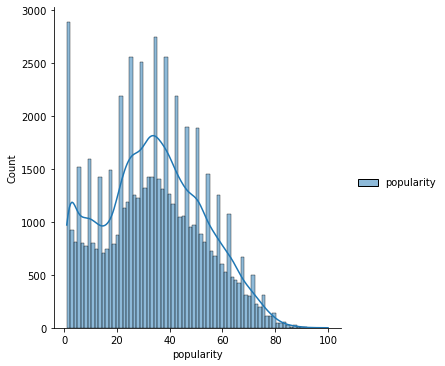

In [24]:
sns.displot(sample_df, kde=True)
plt.xlabel('popularity') 
plt.show()

## Linear Regression Model

**SCALING**

In [32]:
import pyspark.sql.functions as func
# Scale popularity
df1 = df.withColumn('popularity_final',
                   func.round(df['popularity']/100, 2)) \
        .withColumn('duration_min',
                   func.round(df['duration_ms']/60000, 2))\
        .withColumn('instrumentalness_final',
                   func.round(df['instrumentalness'] *1000, 2))

**SELECT AND STANDARDIZE FEATURES**

In [33]:
vars_to_keep = ['popularity_final',
                'acousticness',
                'danceability',
                'duration_min', 
                'energy',
                'instrumentalness_final',
                'liveness',
                'loudness',
                'speechiness',
                'tempo',
                'valence',
                'year']

# subset the dataframe on these predictors
df1 = df1.select(vars_to_keep)
df1.show(1)

+----------------+------------+------------+------------+------+----------------------+--------+--------+-----------+------+-------+----+
|popularity_final|acousticness|danceability|duration_min|energy|instrumentalness_final|liveness|loudness|speechiness| tempo|valence|year|
+----------------+------------+------------+------------+------+----------------------+--------+--------+-----------+------+-------+----+
|            0.04|       0.995|       0.644|        2.53| 0.123|                 858.0|   0.218| -18.648|      0.394|189.67|  0.787|1925|
+----------------+------------+------------+------------+------+----------------------+--------+--------+-----------+------+-------+----+
only showing top 1 row



In [34]:
# Popularity_final V.S. Features
features= ['acousticness',
           'danceability',
           'duration_min',
           'energy', 
           'instrumentalness_final',
           'liveness',
           'loudness', 
           'speechiness',
           'tempo',
           'valence',
           'year']

assembler = VectorAssembler(
    inputCols = features, 
    outputCol = "features") 
df1 = assembler.transform(df1)

In [35]:
df1 = df1.select(["popularity_final",'features']) \
       .withColumnRenamed("popularity_final", 'label')
df1.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
| 0.04|[0.99500000476837...|
| 0.01|[0.94199997186660...|
| 0.06|[0.99599999189376...|
| 0.09|[0.98400002717971...|
| 0.05|[0.99400001764297...|
+-----+--------------------+
only showing top 5 rows



In [36]:
## Feature scaling
# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled", 
                                withStd=True, withMean=False)

# Fit the DataFrame to the scaler; this computes the mean, standard deviation of each feature
scaler = standardScaler.fit(df1)

# Transform the data in `df2` with the scaler
scaled_df = scaler.transform(df1)

In [37]:
# Split data into train set (80%), test set (20%) 
seed = 314
train_test = [0.8, 0.2]
train_data, test_data = scaled_df.randomSplit(train_test, seed)

In [38]:
train_data.show(3)

+-----+--------------------+--------------------+
|label|            features|     features_scaled|
+-----+--------------------+--------------------+
| 0.01|[0.00431999983265...|[0.01201343090100...|
| 0.01|[0.00543999997898...|[0.01512802462513...|
| 0.01|[0.00832999963313...|[0.02316478677648...|
+-----+--------------------+--------------------+
only showing top 3 rows



In [39]:
train_df1 = train_data

In [40]:
lr = LinearRegression(featuresCol = 'features', labelCol='label',
                      maxIter=10, regParam=0.0, elasticNetParam=0 )
model = lr.fit(train_df1)
prediction = model.transform(test_data)

print("Coefficients: " + str(model.coefficients))
print("Intercept: " + str(model.intercept))

Coefficients: [-0.05159956618065999,0.04517695621950297,0.002623510793655334,-0.07041051941910124,-9.71051377583575e-05,-0.08995598421907014,0.002688573933288119,-0.07498987688119269,-4.892637128381571e-05,-0.001634603263675106,0.004346324887787889]
Intercept: -8.175286547394288


In [41]:
trainingSummary = model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 0.150262
r2: 0.372098


In [42]:
train_data.describe().toPandas()

,summary,label
0,count,105482
1,mean,0.33773591702849765
2,stddev,0.18962863965467502
3,min,0.01
4,max,1.0


In [43]:
prediction = model.transform(test_data)
prediction.select("prediction","label","features").show(5)

+-------------------+-----+--------------------+
|         prediction|label|            features|
+-------------------+-----+--------------------+
| 0.4857078979875382| 0.01|[0.03579999879002...|
|0.03922009153621353| 0.01|[0.53600001335144...|
|0.02090757405821897| 0.01|[0.94199997186660...|
|0.19152939607657515| 0.02|[0.83099997043609...|
| 0.1735809864472344| 0.02|[0.93999999761581...|
+-------------------+-----+--------------------+
only showing top 5 rows



In [44]:
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(prediction))

R Squared (R2) on test data = 0.369774


In [45]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

numIterations: 1
objectiveHistory: [0.0]
+--------------------+
|           residuals|
+--------------------+
| -0.4136112799876359|
|-0.45904168430537573|
|-0.48268302904308924|
|-0.04063393142501127|
|-0.17263851720503331|
| -0.2195522717889895|
| -0.2144060470231055|
|-0.01664467682864...|
| -0.1911742419140443|
|-0.12134235379400928|
|-0.00239288297323...|
| -0.2025596126501943|
|-0.10473984051743358|
| 0.01176296162517886|
| -0.4664046225048568|
|-0.40937989355435667|
| -0.4590695085132359|
|-0.47611057276309543|
|-0.35033648342606005|
|  -0.347910666290868|
+--------------------+
only showing top 20 rows



## Random Forest

In [46]:
# IMPORT
import numpy
from numpy import allclose
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import RandomForestClassifier

In [47]:
# PREPARE DATA
stringIndexer = StringIndexer(inputCol="label", outputCol="indexed")
si_model = stringIndexer.fit(df1)
td = si_model.transform(df1)

In [48]:
# BUILD THE MODEL
rf = RandomForestClassifier(numTrees=11, maxDepth=2, labelCol="indexed", seed=314)
model = rf.fit(td)

In [49]:
# FEATURE IMPORTANCES
print(model.featureImportances)

(11,[0,3,4,6,10],[0.157634636943027,0.1339869192495287,0.009086296198294668,0.08243205274290422,0.6168600948662454])


///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

In [50]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.util import MLUtils

In [51]:
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(df1)

# Split the data into training and test sets (20% held out for testing)
(trainingData, testData) = df1.randomSplit([0.8, 0.2])

# Train a RandomForest model.
rf = RandomForestRegressor(featuresCol="indexedFeatures")

# Chain indexer and forest in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, rf])

# Train model.  This also runs the indexer.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("prediction", "label", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print ("Root Mean Squared Error (RMSE) on test data = %g" % rmse)


r2_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="r2")
print("R Squared (R2) on test data = %g" % r2_evaluator.evaluate(predictions))

rfModel = model.stages[1]
print (rfModel) # summary only

+------------------+-----+--------------------+
|        prediction|label|            features|
+------------------+-----+--------------------+
|0.2351986637528467| 0.01|[0.57599997520446...|
|0.1452164163052471| 0.01|[0.98799997568130...|
|0.3361403060621463| 0.02|[0.00418000016361...|
|0.5054291416073906| 0.02|[0.42199999094009...|
|0.1610515219357835| 0.04|[0.74599999189376...|
+------------------+-----+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 0.140613
R Squared (R2) on test data = 0.451537
RandomForestRegressionModel: uid=RandomForestRegressor_5eb6872ee524, numTrees=20, numFeatures=11


## Decision Tree

In [52]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'label')
model = dt.fit(train_data)
prediction = model.transform(test_data)
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(prediction)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.139498


In [53]:
model.featureImportances

SparseVector(11, {0: 0.0159, 2: 0.0188, 4: 0.0881, 5: 0.0065, 6: 0.0169, 7: 0.0005, 10: 0.8533})

In [54]:
df1.take(1)

[Row(label=0.04, features=DenseVector([0.995, 0.644, 2.53, 0.123, 858.0, 0.218, -18.648, 0.394, 189.67, 0.787, 1925.0]))]

///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

In [55]:
featureIndexer = VectorIndexer(inputCol = "features", outputCol = "indexedFeatures").fit(df1)

(trainingData, testData) = df1.randomSplit([0.8, 0.2])

dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'label')

pipeline = Pipeline(stages =[featureIndexer, dt])

model = pipeline.fit(trainingData)

predictions = model.transform(testData)

In [56]:
predictions.select("prediction", "label", "features").show(10)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

r2_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="r2")
print("R Squared (R2) on test data = %g" % r2_evaluator.evaluate(predictions))

treeModel = model.stages[1]
# summary only
print(treeModel)

+-------------------+-----+--------------------+
|         prediction|label|            features|
+-------------------+-----+--------------------+
|0.08058719560094266| 0.01|[0.85199999809265...|
|0.08058719560094266| 0.01|[0.97399997711181...|
|0.10684787018255577| 0.01|[0.97899997234344...|
| 0.5120192856689716| 0.02|[0.22200000286102...|
| 0.5120192856689716| 0.02|[0.42199999094009...|
|0.45201884768617845| 0.02|[0.81199997663497...|
|0.08058719560094266| 0.03|[0.97299998998641...|
|0.17025593299208938| 0.04|[2.11999995372025...|
|0.10684787018255577| 0.04|[0.54400002956390...|
|0.12919354838709676| 0.04|[0.64700001478195...|
+-------------------+-----+--------------------+
only showing top 10 rows

Root Mean Squared Error (RMSE) on test data = 0.140137
R Squared (R2) on test data = 0.452059
DecisionTreeRegressionModel: uid=DecisionTreeRegressor_ec2e09ca84ef, depth=5, numNodes=63, numFeatures=11


## Gradient-boosted Tree Regression

In [63]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'label', maxIter=10,
                   maxDepth=5, )
gbt_model = gbt.fit(train_data)
gbt_predictions = gbt_model.transform(test_data)
gbt_predictions.select('prediction', 'label', 'features').show(5)

+--------------------+-----+--------------------+
|          prediction|label|            features|
+--------------------+-----+--------------------+
|  0.4629138125971539| 0.01|[0.03579999879002...|
|0.027197605208568558| 0.01|[0.53600001335144...|
| 0.09261595311082287| 0.01|[0.94199997186660...|
| 0.11043474182985684| 0.02|[0.83099997043609...|
| 0.10252228622600336| 0.02|[0.93999999761581...|
+--------------------+-----+--------------------+
only showing top 5 rows



In [64]:
gbt_evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.133273


///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

In [65]:
featureIndexer = VectorIndexer(inputCol = "features", outputCol = "indexedFeatures").fit(df1)

(trainingData, testData) = df1.randomSplit([0.8, 0.2])

gbt = GBTRegressor(featuresCol = 'features', labelCol = 'label', maxIter=10, maxDepth = 10)

pipeline = Pipeline(stages =[featureIndexer, gbt])

model = pipeline.fit(trainingData)

predictions = model.transform(testData)

In [66]:
predictions.select("prediction", "label", "features").show(10)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

r2_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="r2")
print("R Squared (R2) on test data = %g" % r2_evaluator.evaluate(predictions))

+--------------------+-----+--------------------+
|          prediction|label|            features|
+--------------------+-----+--------------------+
| 0.10531503812853413| 0.01|[0.00431999983265...|
|  0.4536541317610295| 0.01|[0.00832999963313...|
|  0.1725014328161872| 0.01|[0.79799997806549...|
|  0.5357159883881433| 0.02|[0.42199999094009...|
|-0.05809302409012788| 0.02|[0.85500001907348...|
| 0.08479023368293434| 0.02|[0.93999999761581...|
|  0.1096837652872323| 0.03|[0.80400002002716...|
| 0.14814595830483185| 0.04|[0.83600002527236...|
| 0.08688367126909961| 0.04|[0.98500001430511...|
| 0.06523003323308384| 0.04|[0.99500000476837...|
+--------------------+-----+--------------------+
only showing top 10 rows

Root Mean Squared Error (RMSE) on test data = 0.129835
R Squared (R2) on test data = 0.534421
